In [ ]:
import sys
sys.path.insert(0, "../")
import numpy as np
from dataset import create_dataset_approx
from structure_compare.compare_pairs import StructureComparePair
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

## Loading Data

In [ ]:
train_set, _, _, test_set = create_dataset_approx("cifar10")
x_train, y_train, x_test, y_test = train_set.data/255.0, train_set.targets, test_set.data/255.0, test_set.targets

## Deprecated Comparison Scheme

### Computing Distance between Classes (Deprecated)

In [ ]:
class_0_examples, class_1_examples = x_train[y_train == 4], x_train[y_train == 9]
class_0_examples = class_0_examples.reshape(class_0_examples.shape[0], -1)
class_1_examples = class_1_examples.reshape(class_1_examples.shape[0], -1)
class_1_examples = np.random.randn(*class_1_examples.shape)
class_0_examples = np.random.randn(*class_0_examples.shape)

all_examples = x_train.reshape(x_train.shape[0], -1)

compare_pair = StructureComparePair(x1= class_0_examples, x2= class_1_examples, retain_var= 0.99)


In [ ]:
block_sizes = [1, 10, 40, 100, 200]
distance_scores = []
for block_size in block_sizes:
    curr_block_size_score = []
    for thresh_start in range(0, block_size * (compare_pair.retained_vals // block_size), block_size):
        curr_block_size_score.append(compare_pair.compare_all_coeffs(threshold_start=thresh_start, threshold_end=thresh_start+block_size))

    distance_scores.append((curr_block_size_score, block_size))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

for (block_size_dist, block_size) in distance_scores:
    indices = np.arange(start = 0, stop = block_size * (compare_pair.retained_vals // block_size), step = block_size)
    ax.plot(indices, block_size_dist/(np.sqrt(block_size)), label = block_size)
    ax.set_yscale("log")
    break
ax.legend()

### Comparing Projection Coefficients using 2-Sample T-Test (Deprecated)

In [ ]:
from scipy.stats import ttest_ind

max_val = compare_pair.retained_vals
t_stats = []
pvals = []

for ind in range(0, max_val, 5):
    x1_coefficients_ind = compare_pair.x1_proj_coeffs[:, ind]
    x2_coefficients_ind = compare_pair.x2_proj_coeffs[:, ind]
    t_stat, p = ttest_ind(x1_coefficients_ind, x2_coefficients_ind)
    t_stats.append(t_stat)
    pvals.append(p)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.scatter(np.arange(start = 0, stop = max_val, step = 5), np.array(pvals))
# ax.set_xscale("log")

In [ ]:
plt.hist(pvals)

## Comparing Most to Least Representative Class Elements

### Testing Implementation

In [11]:
class_0_examples, class_1_examples = x_train[y_train == 0], x_train[y_train == 1]
class_0_examples = class_0_examples.reshape(class_0_examples.shape[0], -1)
class_1_examples = class_1_examples.reshape(class_1_examples.shape[0], -1)
# class_1_examples = np.random.randn(*class_1_examples.shape)
# class_0_examples = np.random.randn(*class_0_examples.shape)

all_examples = x_train.reshape(x_train.shape[0], -1)
num_divisions = 8

compare_pair = StructureComparePair(x1= class_0_examples, x2= class_1_examples, retain_var= 0.96, num_divisions = num_divisions, set_all= False, rank_mode= "projection")


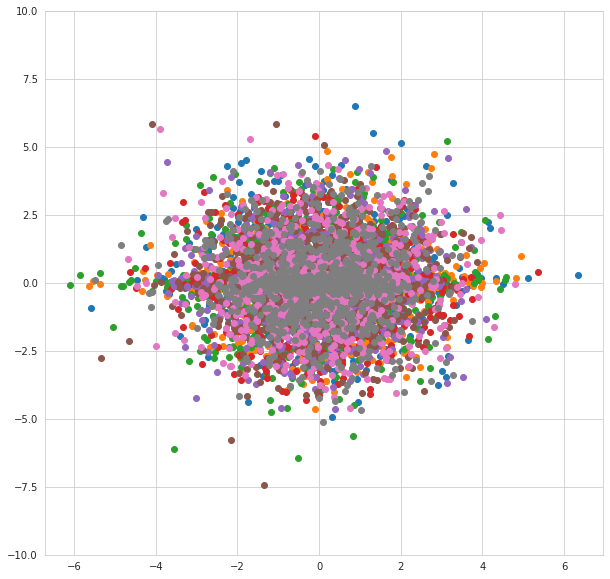

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
for i in range(num_divisions):
    relevant_x1_coeffs = compare_pair.x1_div_coeffs[i]
    relevant_x2_coeffs = compare_pair.x2_div_coeffs[i]
    
    ax.scatter(np.vstack((relevant_x1_coeffs[:, 10], relevant_x2_coeffs[:, 10])), np.vstack((relevant_x1_coeffs[:, 100], relevant_x2_coeffs[:, 100])), label = f"group {i}")
    ax.set_ylim([-10, 10])
    
#plt.legend()

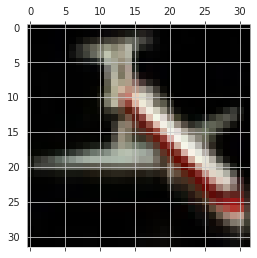

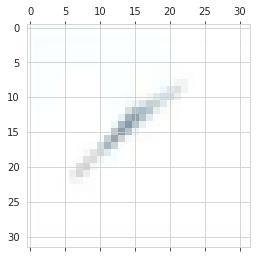

In [13]:
plt.matshow(compare_pair.x1_divided[0][0].reshape(32, 32, 3))
plt.matshow(compare_pair.x1_divided[num_divisions-1][-1].reshape(32, 32, 3))

In [14]:
overlaps = compare_pair.compute_overlap(block_size= 30)

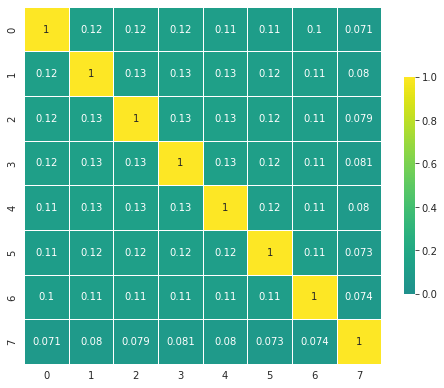

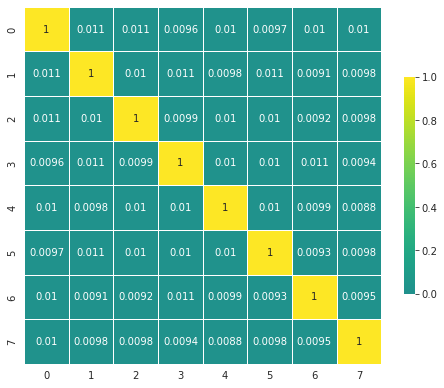

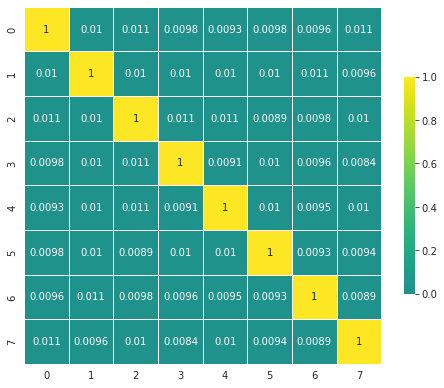

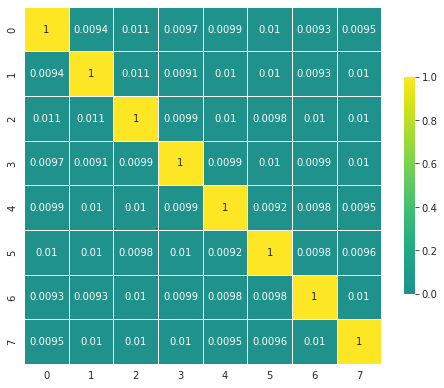

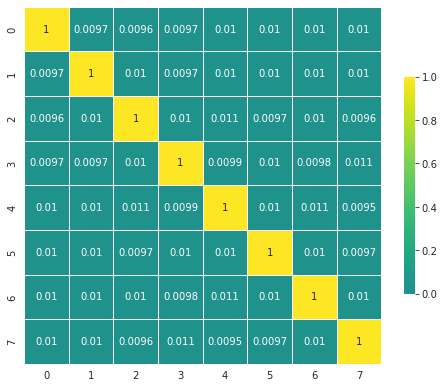

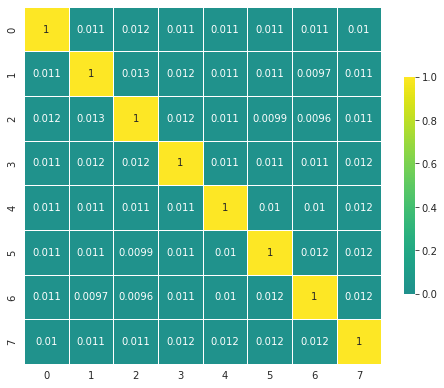

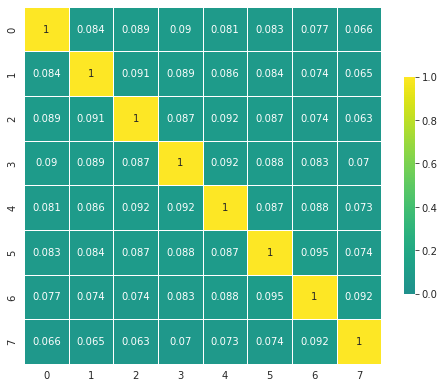

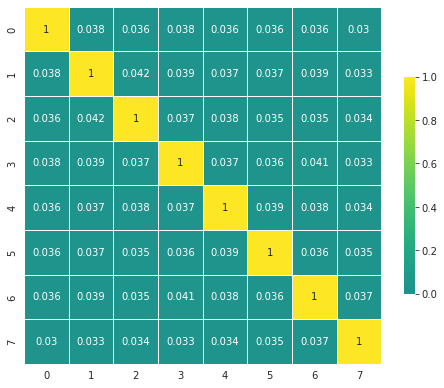

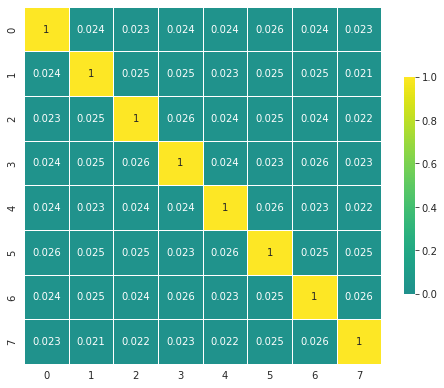

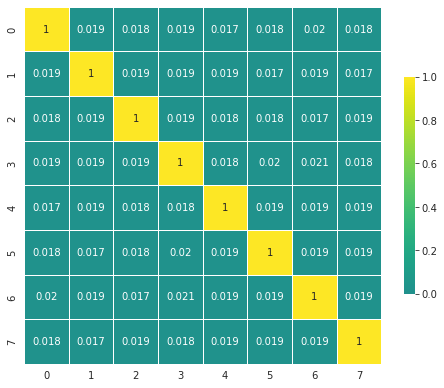

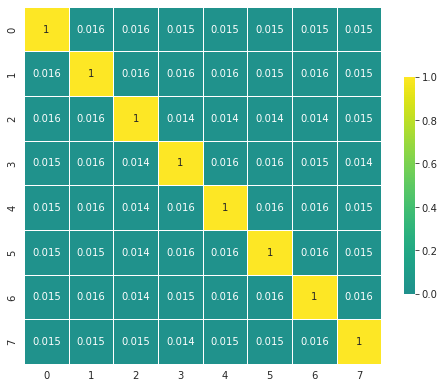

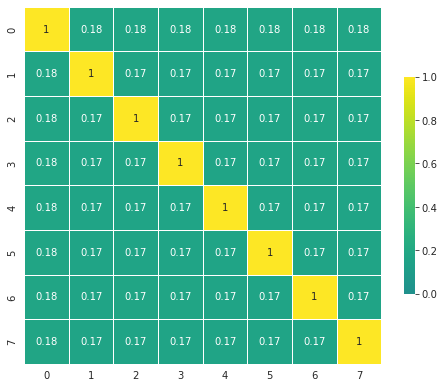

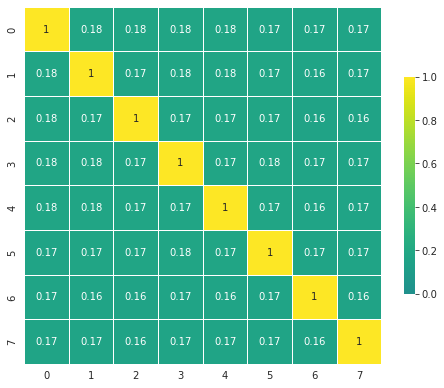

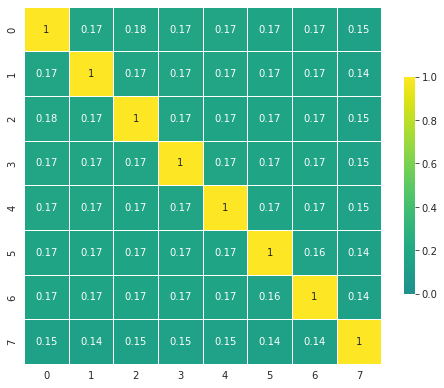

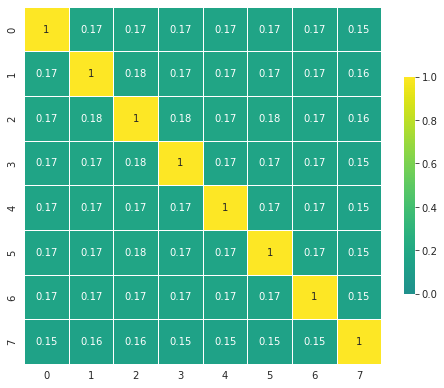

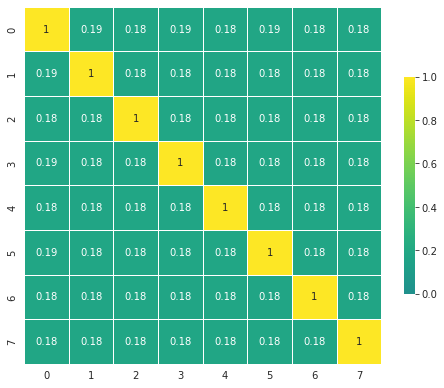

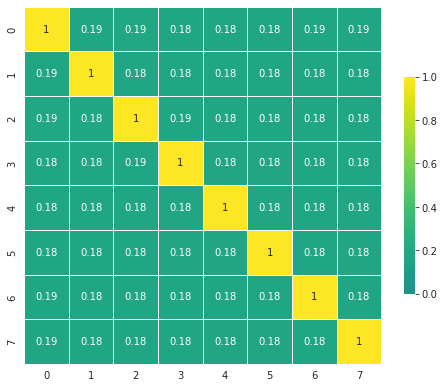

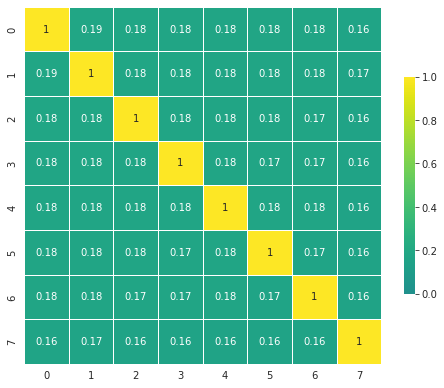

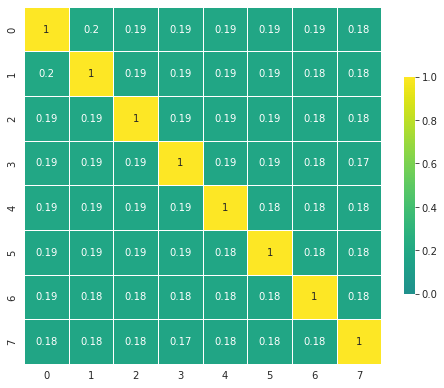

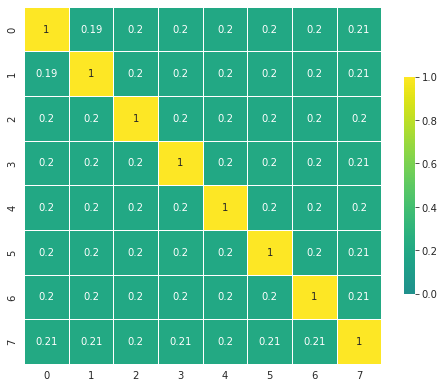

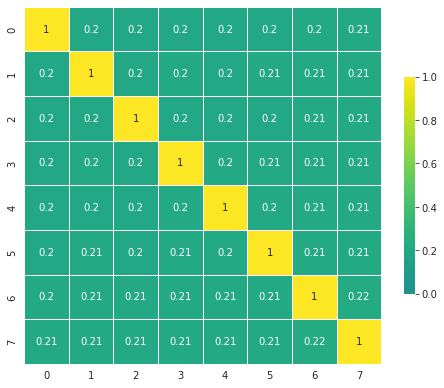

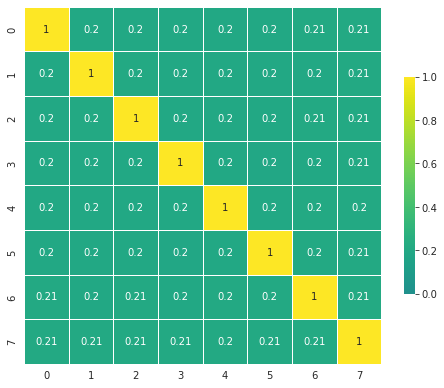

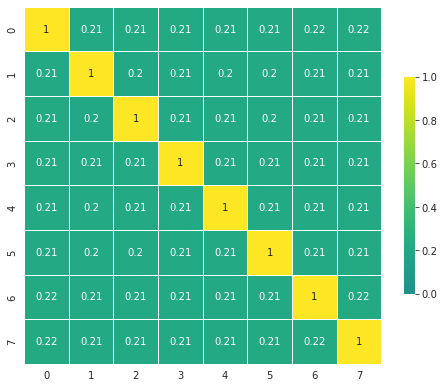

In [15]:
# Generate a mask for the upper triangle
block_correlations = []
num_plots = 20
interval = overlaps.shape[2] // num_plots

for block in range(0, overlaps.shape[2]):
    corr = overlaps[:,:,block] + overlaps[:,:, block].T - np.diag(np.diag(overlaps[:,:,block]))
    if (block % interval) == 0:
        f, ax = plt.subplots(figsize=(8,8))

        sns.heatmap(corr, annot = True, mask=None, vmax=1, vmin = 0, center=0,
                    square=True, linewidths=.5, cmap = "viridis", cbar_kws={"shrink": .5})
        
    block_correlations.append(np.sum(overlaps[:,:,block] - np.diag(np.diag(overlaps[:,:,block])))/(compare_pair.num_divisions*(compare_pair.num_divisions - 1)/2))
    plt.show()

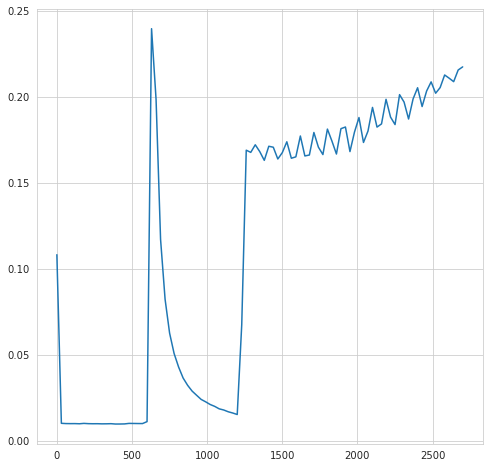

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (8,8))
ax.plot((compare_pair.div_retained_vals//overlaps.shape[2])*np.arange(0, overlaps.shape[2]), block_correlations)

In [ ]:
overlaps[:,:,block]

### Iterating Over (Class 1, Class j) pairs

In [3]:
pair_correlations = []
num_divisions = 8
for i in range(1, 10):
    class_0_examples, class_1_examples = x_train[y_train == 0], x_train[y_train == i]
    class_0_examples = class_0_examples.reshape(class_0_examples.shape[0], -1)
    class_1_examples = class_1_examples.reshape(class_1_examples.shape[0], -1)
    compare_pair = StructureComparePair(x1= class_0_examples, x2= class_1_examples, retain_var= 0.96, num_divisions = num_divisions, set_all= False, rank_mode= "projection")

    overlaps = compare_pair.compute_overlap(block_size= 30)

    block_correlations = []

    for block in range(0, overlaps.shape[2]):
        block_correlations.append(np.sum(overlaps[:,:,block] - np.diag(np.diag(overlaps[:,:,block])))/(compare_pair.num_divisions*(compare_pair.num_divisions - 1)/2))
    
    inds = (compare_pair.div_retained_vals//overlaps.shape[2])*np.arange(0, overlaps.shape[2])
    pair_correlations.append((inds, block_correlations))
        

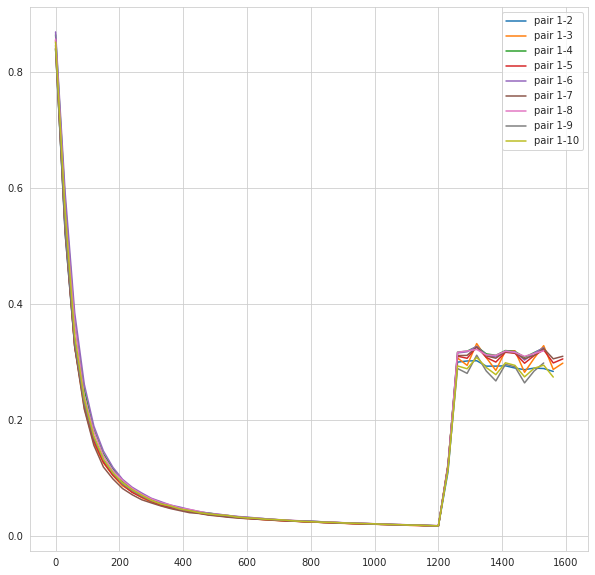

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
i = 1
for (inds, pair_correlation) in pair_correlations:
    i += 1
    ax.plot(inds, pair_correlation, label = f"pair 1-{i}")
    # ax.set_xlim([0, 100])
ax.legend()